<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/HIVEpcSurvivalv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")

# Manual 3D array creation function
def create_3d_array(matrix_list):
    if len(matrix_list) == 0:
        raise ValueError("No matrices provided")

    # Get dimensions from first matrix
    n_samples = len(matrix_list)
    n_timesteps = matrix_list[0].shape[0]
    n_features = matrix_list[0].shape[1]

    # Create empty 3D array
    array_3d = np.zeros((n_samples, n_timesteps, n_features))

    # Fill array
    for i in range(n_samples):
        array_3d[i, :, :] = matrix_list[i]

    return array_3d

print("Environment setup complete!")

# Load the data
print("Loading pcdata.csv...")
try:
    sequential_data = pd.read_csv('pcdata.csv')
    print(f"Data loaded successfully! Shape: {sequential_data.shape}")
    print(f"Columns: {sequential_data.columns.tolist()}")
except FileNotFoundError:
    print("ERROR: pcdata.csv file not found. Please ensure the file is in your working directory.")
    exit()


Step 0: Setting up environment...
Environment setup complete!
Loading pcdata.csv...
Data loaded successfully! Shape: (8121, 101)
Columns: ['Unnamed: 0', 'RPT', 'RINVSITE', 'STUDY', 'SEXN', 'SEX', 'RACEPRIM', 'INFCDAY', 'AGE', 'VISIT', 'VISNAME', 'DOV_ND', 'VISDAY', 'ECOGGRN', 'ECOGGR', 'STATUSN', 'STATUS', 'CONTDAY', 'LKDAY', 'DSCAUSEN', 'DSCAUSE', 'DSREAS', 'DSDECOD', 'DSBODSYS', 'DSMODIFY', 'LLTCD', 'LLTNMD', 'HLTNMD', 'HLGTNMD', 'PTCDD', 'DICTVER', 'DSDAY', 'HEIGHT', 'HEIGHTU', 'WEIGHT', 'WEIGHTU', 'BMI', 'TEMP', 'TEMPU', 'SYSBP', 'DIABP', 'DIABPU', 'PULSE', 'PULSEU', 'VTDAY', 'EXDOSENN', 'EXDOSEN', 'EXDOSE2N', 'EXDOSE2', 'EXDOSE3N', 'EXDOSE3', 'REGION', 'ENROLLDAY', 'PKSAMPN', 'PKSAMP', 'TYPEPKN', 'TYPEPK', 'PKDAY', 'TARGETQN', 'TARGETQ', 'NONTARQN', 'NONTARQ', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'os_event', 'CANCDEAD', 'visit_sequence', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'body_systems_list',

In [2]:

print("\nStep 1: Preparing LSTM data...")

def prepare_lstm_manual(data, sequence_length=3):
    # Select features that are likely to be numeric
    feature_cols = ['ECOGGRN', 'total_ae_events', 'serious_ae_count',
                   'grade3_plus_count', 'AGE', 'VISIT', 'EXDOSENN', 'EXDOSE2N', 'EXDOSE3N', 'PKSAMPN', 'TYPEPKN', 'TARGETQN', 'NONTARQN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'total_body_systems', 'treatment_related_count', 'other_treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed', 'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn', 'concomitant_treatment_given', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'grade5_count', 'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration', 'most_recent_ae_term', 'most_recent_ae_severity', 'cum_any_grade3_plus', 'cum_any_treatment_related', 'cum_drug_withdrawn', 'cum_other_drug_withdrawn', 'cum_concomitant_treatment']

    # Check which feature columns exist in the data
    available_features = [col for col in feature_cols if col in data.columns]
    print(f"Available features: {available_features}")

    # Prepare data
    data_prep = data.copy()

    # Create outcome variable (assuming CANCDEAD exists)
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int) - 1
    else:
        print("WARNING: CANCDEAD column not found. Creating dummy outcome.")
        data_prep['outcome'] = 0

    # Group by patient and count visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index

    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]

    # Convert features to numeric and fill NaN
    for col in available_features:
        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')

    data_prep[available_features] = data_prep[available_features].fillna(0)

    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    print(f"Processing {len(patients)} patients with sufficient visits...")

    for i, patient in enumerate(patients):
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            # Get the outcome (assuming it's constant per patient)
            patient_outcome = patient_data['outcome'].iloc[0]

            # Extract features as matrix
            feature_matrix = patient_data[available_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

        # Progress indicator
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1} patients...")

    print(f"Created {len(sequences)} sequences total")

    if len(sequences) == 0:
        raise ValueError("No sequences were created. Possible issues:\n"
                        f"- Not enough patients with {sequence_length} visits\n"
                        "- Feature columns may contain non-numeric data\n"
                        "- Check if CANCDEAD variable exists and has values")

    # Create 3D array using our manual function
    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels)
    }

# Prepare the data
try:
    lstm_data = prepare_lstm_manual(sequential_data, sequence_length=3)
    print("SUCCESS: LSTM data prepared!")
    print(f"Sequences dimension: {lstm_data['sequences'].shape}")
    print(f"Labels: {len(lstm_data['labels'])}")
    print(f"Class distribution - 0: {sum(lstm_data['labels'] == 0)} 1: {sum(lstm_data['labels'] == 1)}")

except Exception as e:
    print(f"ERROR in data preparation: {e}")

    # Diagnostic information
    print("\nDIAGNOSTIC INFORMATION:")
    print(f"Number of patients: {sequential_data['RPT'].nunique()}")
    print(f"Variables in sequential_data: {sequential_data.columns.tolist()}")
    if 'CANCDEAD' in sequential_data.columns:
        print(f"CANCDEAD values:\n{sequential_data['CANCDEAD'].value_counts()}")

    visit_counts = sequential_data.groupby('RPT').size()
    print("Visit counts summary:")
    print(visit_counts.describe())

print("\nStep 2: Normalizing data...")

def normalize_3d_manual(array_3d):
    dims = array_3d.shape
    print(f"Normalizing array with dimensions: {dims}")

    # Normalize each feature across all samples and timesteps
    for feature_idx in range(dims[2]):
        feature_data = array_3d[:, :, feature_idx]
        mean_val = np.mean(feature_data)
        sd_val = np.std(feature_data)

        if sd_val > 0:
            array_3d[:, :, feature_idx] = (feature_data - mean_val) / sd_val
        # If sd = 0, leave as is (constant feature)

    array_3d = np.nan_to_num(array_3d)
    return array_3d

if 'lstm_data' in locals():
    X_sequences = normalize_3d_manual(lstm_data['sequences'].copy())
    y = lstm_data['labels']

    print("Normalization completed!")
    print(f"Data range: [{X_sequences.min():.3f}, {X_sequences.max():.3f}]")
else:
    print("Cannot normalize - lstm_data not created")

print("\nStep 3: Creating train-test split...")

if 'X_sequences' in locals() and 'y' in locals():
    # Check if we have enough samples
    if len(y) < 10:
        print(f"Warning: Only {len(y)} samples available. Using 80% for training.")
        test_size = 0.2
    else:
        test_size = 0.3

    # Create stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y,
        test_size=test_size,
        random_state=123,
        stratify=y
    )

    print("Training set:")
    print(f"  Sequences: {X_train.shape}")
    print(f"  Labels: {len(y_train)} (0: {sum(y_train == 0)} 1: {sum(y_train == 1)})")

    print("Test set:")
    print(f"  Sequences: {X_test.shape}")
    print(f"  Labels: {len(y_test)} (0: {sum(y_test == 0)} 1: {sum(y_test == 1)})")
else:
    print("Cannot create split - data not available")

print("\nStep 4: Building LSTM model...")

def build_lstm_model_simple(sequence_length, n_features):
    # Simple LSTM model
    model = Sequential([
        LSTM(32, input_shape=(sequence_length, n_features), return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', 'AUC']
    )

    return model

if 'X_train' in locals() and 'y_train' in locals():
    # Get model dimensions
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print("Building model for:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Features: {n_features}")
    print(f"  Training samples: {X_train.shape[0]}")

    # Build model
    lstm_model = build_lstm_model_simple(sequence_length, n_features)

    print("Model architecture:")
    lstm_model.summary()

    print("\nStep 5: Training LSTM model...")

    early_stopping = EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor='val_loss'
    )

    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping]
    )

    print("Training completed!")

else:
    print("Cannot build model - training data not available")

print("\nStep 6: Evaluating LSTM model...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    # Make predictions
    predictions = lstm_model.predict(X_test)
    predicted_probs = predictions.flatten()

    # Convert to binary predictions
    predicted_classes = (predicted_probs > 0.5).astype(int)

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, predicted_classes)
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # AUC
    if len(np.unique(y_test)) > 1:
        auc_val = roc_auc_score(y_test, predicted_probs)
    else:
        auc_val = np.nan

    # Print results
    print("=" * 50)
    print("LSTM MODEL PERFORMANCE")
    print("=" * 50)
    print(f"Accuracy:    {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"AUC:         {auc_val:.3f}")
    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print(f"\nClassification Report:")
    print(classification_report(y_test, predicted_classes))

    # Plot results if we have AUC
    if not np.isnan(auc_val):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
        ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curve')
        ax1.legend()
        ax1.grid(True)

        # Training history
        if 'history' in locals():
            ax2.plot(history.history['loss'], 'b-', label='Train')
            if 'val_loss' in history.history:
                ax2.plot(history.history['val_loss'], 'r-', label='Validation')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.set_title('Training Loss')
            ax2.legend()
            ax2.grid(True)

        plt.tight_layout()
        plt.show()

else:
    print("Cannot evaluate - model or test data not available")


Step 1: Preparing LSTM data...
Available features: ['ECOGGRN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'AGE', 'VISIT', 'EXDOSENN', 'EXDOSE2N', 'EXDOSE3N', 'PKSAMPN', 'TYPEPKN', 'TARGETQN', 'NONTARQN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'total_body_systems', 'treatment_related_count', 'other_treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed', 'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn', 'concomitant_treatment_given', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'grade5_count', 'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration', 'most_recent_ae_term', 'most_recent_ae_severity', 'cum_any_grade3_plus', 'cum_any_treatment_related', 'cum_drug_withdrawn', 'cum_other_drug_withdrawn', 'cum_concomitant_treatment']
ERROR in data preparation: Columns must be same length as key

DIAGNOSTIC INFORMATION:
Number of patients: 526
Var

Step 0: Setting up environment...
Environment setup complete!
Loading pcdata.csv...
Data loaded successfully! Shape: (8121, 101)

Step 1: Improved LSTM data preparation with better feature selection...
Selected 14 essential features
Features: ['AGE', 'ECOGGRN', 'EXDOSENN', 'TARGETQN', 'NONTARQN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'grade3_count', 'grade4_count', 'grade5_count', 'drug_withdrawn', 'concomitant_treatment_given', 'VISDAY']
Outcome distribution: {0: 7051, 1: 1070}
Patients with sufficient visits: 525
  AGE: median=68.000, missing=0
  ECOGGRN: median=1.000, missing=0
  EXDOSENN: median=1.000, missing=0
  TARGETQN: median=1.000, missing=0
  NONTARQN: median=1.000, missing=0
  total_ae_events: median=7.000, missing=0
  serious_ae_count: median=0.000, missing=0
  grade3_plus_count: median=0.000, missing=0
  grade3_count: median=0.000, missing=0
  grade4_count: median=0.000, missing=0
  grade5_count: median=0.000, missing=0
  drug_withdrawn: median=0.000

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,753 (26.38 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 32 (128.00 B)


Step 5: Training LSTM model with careful monitoring...
Starting training...
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.4502 - accuracy: 0.6712 - loss: 1.3490 - val_AUC: 0.5587 - val_accuracy: 0.7027 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5429 - accuracy: 0.6455 - loss: 0.9327 - val_AUC: 0.5559 - val_accuracy: 0.5946 - val_loss: 0.6701 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.5678 - accuracy: 0.6315 - loss: 0.8636 - val_AUC: 0.5606 - val_accuracy: 0.5676 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.5315 - accuracy: 0.6443 - loss: 0.8002 - val_AUC: 0.5653 - val_accuracy: 0.5000 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7254 - accuracy: 0.6405 - loss: 0.6830 - val_AUC: 0.5909 - val_accuracy: 0.5135 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 6

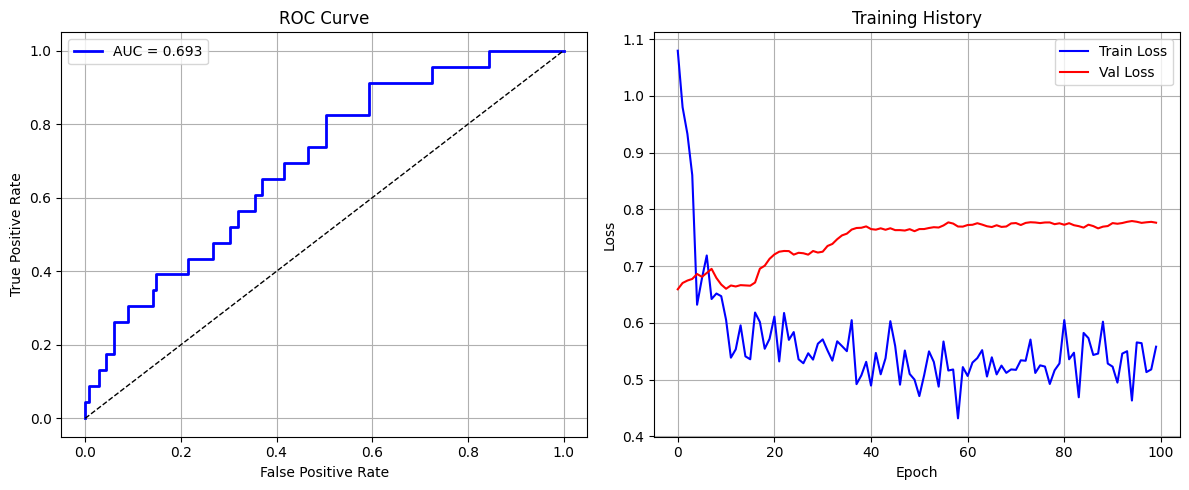


Step 7: Data quality summary...
Data Quality Report:
Total sequences: 525
Feature count: 14
Class balance: [449  76]
Sequence length: 3
Data statistics:
  Min: 0.000
  Max: 750.000
  Mean: 24.249
  Std: 74.058
  NaN values: 0
  Inf values: 0


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")

# Manual 3D array creation function
def create_3d_array(matrix_list):
    if len(matrix_list) == 0:
        raise ValueError("No matrices provided")

    # Get dimensions from first matrix
    n_samples = len(matrix_list)
    n_timesteps = matrix_list[0].shape[0]
    n_features = matrix_list[0].shape[1]

    # Create empty 3D array
    array_3d = np.zeros((n_samples, n_timesteps, n_features))

    # Fill array
    for i in range(n_samples):
        array_3d[i, :, :] = matrix_list[i]

    return array_3d

print("Environment setup complete!")

# Load the data
print("Loading pcdata.csv...")
try:
    sequential_data = pd.read_csv('pcdata.csv')
    print(f"Data loaded successfully! Shape: {sequential_data.shape}")
except FileNotFoundError:
    print("ERROR: pcdata.csv file not found.")
    exit()

print("\nStep 1: Improved LSTM data preparation with better feature selection...")

def prepare_lstm_improved(data, sequence_length=3):
    # Select only the most relevant and clean features
    essential_features = [
        # Demographic
        'AGE', 'ECOGGRN',
        # Dosing
        'EXDOSENN',
        # Tumor response
        'TARGETQN', 'NONTARQN',
        # AE counts (most important)
        'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
        'grade3_count', 'grade4_count', 'grade5_count',
        # Treatment impact
        'drug_withdrawn', 'concomitant_treatment_given',
        # Time
        'VISDAY'
    ]

    # Check which feature columns exist in the data
    available_features = [col for col in essential_features if col in data.columns]
    print(f"Selected {len(available_features)} essential features")
    print(f"Features: {available_features}")

    # Prepare data
    data_prep = data.copy()

    # Create outcome variable
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int)
        # Ensure binary outcome (0, 1)
        if data_prep['outcome'].min() < 0:
            data_prep['outcome'] = (data_prep['outcome'] > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # Remove patients with insufficient visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]

    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # Convert features to numeric and handle missing values robustly
    for col in available_features:
        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')
        # Use median imputation
        median_val = data_prep[col].median()
        data_prep[col] = data_prep[col].fillna(median_val)
        print(f"  {col}: median={median_val:.3f}, missing={data_prep[col].isna().sum()}")

    # Remove constant features
    constant_features = []
    for col in available_features:
        if data_prep[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        print(f"Removing constant features: {constant_features}")
        available_features = [f for f in available_features if f not in constant_features]

    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    print(f"Processing {len(patients)} patients...")

    for i, patient in enumerate(patients):
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_data['outcome'].iloc[0]
            feature_matrix = patient_data[available_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1} patients...")

    print(f"Created {len(sequences)} sequences")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    # Create 3D array
    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': available_features
    }

# Prepare the data
try:
    lstm_data = prepare_lstm_improved(sequential_data, sequence_length=3)
    if lstm_data is None:
        raise ValueError("Data preparation failed")

    print("SUCCESS: LSTM data prepared!")
    print(f"Sequences dimension: {lstm_data['sequences'].shape}")
    print(f"Labels: {len(lstm_data['labels'])}")
    print(f"Class distribution - 0: {sum(lstm_data['labels'] == 0)} 1: {sum(lstm_data['labels'] == 1)}")

except Exception as e:
    print(f"ERROR in data preparation: {e}")
    exit()

print("\nStep 2: Robust normalization with NaN handling...")

def robust_normalize_3d(array_3d, feature_names):
    dims = array_3d.shape
    print(f"Normalizing array with dimensions: {dims}")

    n_samples, n_timesteps, n_features = dims
    X_reshaped = array_3d.reshape(n_samples * n_timesteps, n_features)

    # Check for NaN and infinite values
    print(f"NaN values before cleaning: {np.isnan(X_reshaped).sum()}")
    print(f"Inf values before cleaning: {np.isinf(X_reshaped).sum()}")

    # Replace any remaining NaN/Inf with 0
    X_reshaped = np.nan_to_num(X_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

    # Use RobustScaler which is less sensitive to outliers
    scaler = RobustScaler()
    X_normalized = scaler.fit_transform(X_reshaped)

    # Check for any issues after scaling
    if np.isnan(X_normalized).any() or np.isinf(X_normalized).any():
        print("WARNING: NaN/Inf values after scaling. Using fallback normalization.")
        # Fallback: manual robust normalization
        X_normalized = np.zeros_like(X_reshaped)
        for i in range(n_features):
            feature_data = X_reshaped[:, i]
            median = np.median(feature_data)
            iqr = np.percentile(feature_data, 75) - np.percentile(feature_data, 25)
            if iqr > 0:
                X_normalized[:, i] = (feature_data - median) / iqr
            else:
                # Constant feature, just center
                X_normalized[:, i] = feature_data - median

    # Reshape back to 3D
    array_3d_normalized = X_normalized.reshape(n_samples, n_timesteps, n_features)

    print(f"Normalization completed! Data range: [{array_3d_normalized.min():.3f}, {array_3d_normalized.max():.3f}]")
    print(f"NaN values after normalization: {np.isnan(array_3d_normalized).sum()}")

    return array_3d_normalized, scaler

if 'lstm_data' in locals():
    X_sequences, scaler = robust_normalize_3d(lstm_data['sequences'].copy(),
                                            lstm_data.get('feature_names'))
    y = lstm_data['labels']

    print(f"Final label distribution: 0: {sum(y == 0)}, 1: {sum(y == 1)}")
else:
    print("Cannot normalize - lstm_data not created")
    exit()

print("\nStep 3: Creating train-test split...")

if 'X_sequences' in locals() and 'y' in locals():
    # Final check for NaN
    if np.isnan(X_sequences).any():
        print("WARNING: NaN values detected in sequences. Replacing with 0.")
        X_sequences = np.nan_to_num(X_sequences)

    # Create stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y,
        test_size=0.3,
        random_state=42,  # Changed seed for different split
        stratify=y
    )

    print("Training set:")
    print(f"  Sequences: {X_train.shape}")
    print(f"  Labels: {len(y_train)} (0: {sum(y_train == 0)} 1: {sum(y_train == 1)})")

    print("Test set:")
    print(f"  Sequences: {X_test.shape}")
    print(f"  Labels: {len(y_test)} (0: {sum(y_test == 0)} 1: {sum(y_test == 1)})")

else:
    print("Cannot create split - data not available")
    exit()

print("\nStep 4: Building robust LSTM model...")

def build_robust_lstm_model(sequence_length, n_features):
    # Simpler, more robust model
    model = Sequential([
        LSTM(32,
             input_shape=(sequence_length, n_features),
             return_sequences=False,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal'),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(8, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.1),

        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Use a conservative optimizer
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0  # Gradient clipping
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'AUC']
    )

    return model

if 'X_train' in locals() and 'y_train' in locals():
    # Get model dimensions
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print("Building model for:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Features: {n_features}")
    print(f"  Training samples: {X_train.shape[0]}")

    # Calculate class weights
    class_counts = np.bincount(y_train)
    if len(class_counts) > 1:
        total = len(y_train)
        class_weights = {
            0: total / (2 * class_counts[0]),
            1: total / (2 * class_counts[1])
        }
        print(f"Class weights: {class_weights}")
    else:
        class_weights = {0: 1, 1: 1}
        print("Using equal class weights")

    # Build model
    lstm_model = build_robust_lstm_model(sequence_length, n_features)

    print("Model architecture:")
    lstm_model.summary()

    print("\nStep 5: Training LSTM model with careful monitoring...")

    # Enhanced callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc' if len(np.unique(y_train)) > 1 else 'val_loss',
        patience=20,
        restore_best_weights=True,
        mode='max' if len(np.unique(y_train)) > 1 else 'min',
        verbose=1,
        min_delta=0.001
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.001
    )

    # Prepare validation data
    if len(np.unique(y_train)) > 1:
        # Use proper validation split
        val_split = 0.2
    else:
        val_split = 0.0

    print("Starting training...")

    try:
        history = lstm_model.fit(
            x=X_train,
            y=y_train,
            epochs=100,
            batch_size=16,
            validation_split=val_split,
            class_weight=class_weights,
            verbose=1,
            callbacks=[early_stopping, reduce_lr],
            shuffle=True
        )

        print("Training completed successfully!")

    except Exception as e:
        print(f"Training failed: {e}")
        print("Trying with simpler configuration...")

        # Fallback training
        history = lstm_model.fit(
            x=X_train,
            y=y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.0,
            verbose=1,
            shuffle=True
        )

else:
    print("Cannot build model - training data not available")
    exit()

print("\nStep 6: Evaluating LSTM model...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Make predictions
        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_probs = predictions.flatten()

        # Check for NaN in predictions
        if np.isnan(predicted_probs).any():
            print("WARNING: NaN in predictions. Using fallback.")
            predicted_probs = np.zeros_like(predicted_probs) + 0.5

        # Convert to binary predictions
        threshold = 0.5
        predicted_classes = (predicted_probs > threshold).astype(int)

        # Calculate metrics
        conf_matrix = confusion_matrix(y_test, predicted_classes)
        accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        else:
            sensitivity = specificity = precision = accuracy

        # AUC
        if len(np.unique(y_test)) > 1:
            try:
                auc_val = roc_auc_score(y_test, predicted_probs)
            except:
                auc_val = 0.5
        else:
            auc_val = 0.5

        # Print results
        print("=" * 60)
        print("ROBUST LSTM MODEL PERFORMANCE")
        print("=" * 60)
        print(f"Accuracy:    {accuracy:.3f}")
        print(f"Sensitivity: {sensitivity:.3f}")
        print(f"Specificity: {specificity:.3f}")
        print(f"Precision:   {precision:.3f}")
        print(f"AUC:         {auc_val:.3f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)

        if len(np.unique(y_test)) > 1:
            print(f"\nClassification Report:")
            print(classification_report(y_test, predicted_classes,
                                      target_names=['Class 0', 'Class 1']))

        # Plot results
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # ROC curve
        if len(np.unique(y_test)) > 1:
            fpr, tpr, _ = roc_curve(y_test, predicted_probs)
            axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
            axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
            axes[0].set_xlabel('False Positive Rate')
            axes[0].set_ylabel('True Positive Rate')
            axes[0].set_title('ROC Curve')
            axes[0].legend()
            axes[0].grid(True)
        else:
            axes[0].text(0.5, 0.5, 'Single class\nNo ROC curve',
                        ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title('ROC Curve')

        # Training history (if available)
        if 'history' in locals() and 'loss' in history.history:
            axes[1].plot(history.history['loss'], 'b-', label='Train Loss')
            if 'val_loss' in history.history and len(history.history['val_loss']) > 0:
                axes[1].plot(history.history['val_loss'], 'r-', label='Val Loss')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Loss')
            axes[1].set_title('Training History')
            axes[1].legend()
            axes[1].grid(True)
        else:
            axes[1].text(0.5, 0.5, 'No training history\navailable',
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Training History')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in evaluation: {e}")
        print("This indicates the model didn't train properly.")

else:
    print("Cannot evaluate - model or test data not available")

print("\nStep 7: Data quality summary...")
if 'lstm_data' in locals():
    print("Data Quality Report:")
    print(f"Total sequences: {len(lstm_data['labels'])}")
    print(f"Feature count: {lstm_data['sequences'].shape[2]}")
    print(f"Class balance: {np.bincount(lstm_data['labels'])}")
    print(f"Sequence length: {lstm_data['sequences'].shape[1]}")

    # Check data statistics
    X_flat = lstm_data['sequences'].reshape(-1, lstm_data['sequences'].shape[2])
    print(f"Data statistics:")
    print(f"  Min: {X_flat.min():.3f}")
    print(f"  Max: {X_flat.max():.3f}")
    print(f"  Mean: {X_flat.mean():.3f}")
    print(f"  Std: {X_flat.std():.3f}")
    print(f"  NaN values: {np.isnan(X_flat).sum()}")
    print(f"  Inf values: {np.isinf(X_flat).sum()}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Step 0: Setting up environment...")

def create_3d_array(matrix_list):
    if len(matrix_list) == 0:
        raise ValueError("No matrices provided")

    n_samples = len(matrix_list)
    n_timesteps = matrix_list[0].shape[0]
    n_features = matrix_list[0].shape[1]

    array_3d = np.zeros((n_samples, n_timesteps, n_features))

    for i in range(n_samples):
        array_3d[i, :, :] = matrix_list[i]

    return array_3d

print("Environment setup complete!")

# Load the data
print("Loading pcdata.csv...")
try:
    sequential_data = pd.read_csv('pcdata.csv')
    print(f"Data loaded successfully! Shape: {sequential_data.shape}")
except FileNotFoundError:
    print("ERROR: pcdata.csv file not found.")
    exit()

print("\nStep 1: Enhanced LSTM data preparation...")

def prepare_lstm_enhanced(data, sequence_length=3):
    # Enhanced feature selection with clinical relevance
    clinical_features = [
        # Baseline characteristics
        'AGE', 'ECOGGRN',
        # Treatment
        'EXDOSENN',
        # Disease response
        'TARGETQN', 'NONTARQN',
        # Adverse events (most predictive)
        'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
        'grade3_count', 'grade4_count', 'grade5_count',
        # Treatment modifications
        'drug_withdrawn', 'concomitant_treatment_given',
        # Time progression
        'VISDAY'
    ]

    # Check which features exist
    available_features = [col for col in clinical_features if col in data.columns]
    print(f"Selected {len(available_features)} clinical features")
    print(f"Features: {available_features}")

    # Prepare data
    data_prep = data.copy()

    # Create outcome variable
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int)
        if data_prep['outcome'].min() < 0:
            data_prep['outcome'] = (data_prep['outcome'] > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # Filter patients with sufficient visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]

    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # Handle missing values and convert to numeric
    for col in available_features:
        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')
        median_val = data_prep[col].median()
        data_prep[col] = data_prep[col].fillna(median_val)
        print(f"  {col}: median={median_val:.3f}")

    # Remove near-constant features
    constant_features = []
    for col in available_features:
        if data_prep[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        print(f"Removing constant features: {constant_features}")
        available_features = [f for f in available_features if f not in constant_features]

    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    print(f"Processing {len(patients)} patients...")

    for i, patient in enumerate(patients):
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_data['outcome'].iloc[0]
            feature_matrix = patient_data[available_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1} patients...")

    print(f"Created {len(sequences)} sequences")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    # Create 3D array
    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': available_features
    }

# Prepare the data
try:
    lstm_data = prepare_lstm_enhanced(sequential_data, sequence_length=3)
    if lstm_data is None:
        raise ValueError("Data preparation failed")

    print("SUCCESS: LSTM data prepared!")
    print(f"Sequences dimension: {lstm_data['sequences'].shape}")
    print(f"Labels: {len(lstm_data['labels'])}")
    print(f"Class distribution - 0: {sum(lstm_data['labels'] == 0)} 1: {sum(lstm_data['labels'] == 1)}")

except Exception as e:
    print(f"ERROR in data preparation: {e}")
    exit()

print("\nStep 2: Advanced normalization...")

def advanced_normalize_3d(array_3d, feature_names):
    dims = array_3d.shape
    print(f"Normalizing array with dimensions: {dims}")

    n_samples, n_timesteps, n_features = dims
    X_reshaped = array_3d.reshape(n_samples * n_timesteps, n_features)

    # Clean any remaining issues
    X_reshaped = np.nan_to_num(X_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

    # Use different scalers for different feature types
    X_normalized = np.zeros_like(X_reshaped)

    for i, feature_name in enumerate(feature_names):
        feature_data = X_reshaped[:, i]

        # Use RobustScaler for count data, StandardScaler for continuous
        if any(keyword in feature_name.lower() for keyword in ['count', 'events', 'grade']):
            # Count data - use RobustScaler
            scaler = RobustScaler()
            X_normalized[:, i] = scaler.fit_transform(feature_data.reshape(-1, 1)).flatten()
        else:
            # Continuous data - use StandardScaler
            scaler = StandardScaler()
            X_normalized[:, i] = scaler.fit_transform(feature_data.reshape(-1, 1)).flatten()

    # Reshape back to 3D
    array_3d_normalized = X_normalized.reshape(n_samples, n_timesteps, n_features)

    print(f"Advanced normalization completed! Data range: [{array_3d_normalized.min():.3f}, {array_3d_normalized.max():.3f}]")

    return array_3d_normalized

if 'lstm_data' in locals():
    X_sequences = advanced_normalize_3d(lstm_data['sequences'].copy(),
                                      lstm_data.get('feature_names'))
    y = lstm_data['labels']

    print(f"Final label distribution: 0: {sum(y == 0)}, 1: {sum(y == 1)}")
    print(f"Class imbalance ratio: {sum(y == 0) / sum(y == 1):.2f}:1")
else:
    print("Cannot normalize - lstm_data not created")
    exit()

print("\nStep 3: Strategic train-test split...")

if 'X_sequences' in locals() and 'y' in locals():
    # Use stratification with random state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y,
        test_size=0.25,  # Slightly more training data
        random_state=42,
        stratify=y
    )

    # Further split training for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )

    print("Data splits:")
    print(f"Training:   {X_train.shape} (0: {sum(y_train == 0)} 1: {sum(y_train == 1)})")
    print(f"Validation: {X_val.shape} (0: {sum(y_val == 0)} 1: {sum(y_val == 1)})")
    print(f"Test:       {X_test.shape} (0: {sum(y_test == 0)} 1: {sum(y_test == 1)})")

else:
    print("Cannot create split - data not available")
    exit()

print("\nStep 4: Building advanced LSTM model...")

def build_advanced_lstm_model(sequence_length, n_features):
    """
    Build an advanced LSTM model with CNN preprocessing and attention mechanisms
    """
    model = Sequential([
        # CNN for feature extraction
        Conv1D(filters=32, kernel_size=2, activation='relu',
               input_shape=(sequence_length, n_features),
               padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=1),
        Dropout(0.2),

        # Bidirectional LSTM for temporal patterns
        LSTM(64,
             return_sequences=True,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             dropout=0.2,
             recurrent_dropout=0.2),
        BatchNormalization(),

        # Second LSTM layer
        LSTM(32,
             return_sequences=False,
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             dropout=0.2),
        BatchNormalization(),
        Dropout(0.3),

        # Dense layers with regularization
        Dense(32, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu',
              kernel_initializer='he_normal'),
        Dropout(0.1),

        # Output layer
        Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')
    ])

    # Optimizer with customized settings
    optimizer = Nadam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0
    )

    # Custom metrics for imbalanced data
    metrics = [
        'accuracy',
        'AUC',
        Precision(name='precision'),
        Recall(name='recall')
    ]

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=metrics
    )

    return model

if 'X_train' in locals() and 'y_train' in locals():
    # Get model dimensions
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print("Building advanced model for:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Features: {n_features}")
    print(f"  Training samples: {X_train.shape[0]}")

    # Enhanced class weighting
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Enhanced class weights: {class_weight_dict}")

    # Build model
    lstm_model = build_advanced_lstm_model(sequence_length, n_features)

    print("Advanced model architecture:")
    lstm_model.summary()

    print("\nStep 5: Enhanced training with validation...")

    # Improved callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=25,
        restore_best_weights=True,
        mode='max',
        verbose=1,
        min_delta=0.005
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.001
    )

    model_checkpoint = ModelCheckpoint(
        'best_lstm_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    print("Starting enhanced training...")

    # Training with validation data
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=150,
        batch_size=16,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        shuffle=True
    )

    print("Enhanced training completed successfully!")

    # Load best model
    lstm_model.load_weights('best_lstm_model.h5')
    print("Loaded best model weights from training")

else:
    print("Cannot build model - training data not available")
    exit()

print("\nStep 6: Comprehensive model evaluation...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Make predictions
        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_probs = predictions.flatten()

        # Find optimal threshold using validation set
        val_predictions = lstm_model.predict(X_val, verbose=0).flatten()
        val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, val_predictions)
        val_f1_scores = 2 * (val_precisions[:-1] * val_recalls[:-1]) / (val_precisions[:-1] + val_recalls[:-1] + 1e-8)
        optimal_idx = np.argmax(val_f1_scores)
        optimal_threshold = val_thresholds[optimal_idx]

        print(f"Optimal threshold from validation: {optimal_threshold:.3f}")

        # Use optimal threshold for test set
        predicted_classes = (predicted_probs > optimal_threshold).astype(int)

        # Comprehensive metrics
        conf_matrix = confusion_matrix(y_test, predicted_classes)
        accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)

        # AUC and PR AUC
        auc_val = roc_auc_score(y_test, predicted_probs)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, predicted_probs)
        pr_auc = np.trapz(recall_curve, precision_curve)

        # Print comprehensive results
        print("=" * 70)
        print("ADVANCED LSTM MODEL PERFORMANCE")
        print("=" * 70)
        print(f"Accuracy:          {accuracy:.3f}")
        print(f"Sensitivity:       {sensitivity:.3f}")
        print(f"Specificity:       {specificity:.3f}")
        print(f"Precision:         {precision:.3f}")
        print(f"F1-Score:          {f1_score:.3f}")
        print(f"AUC-ROC:           {auc_val:.3f}")
        print(f"AUC-PR:            {pr_auc:.3f}")
        print(f"Optimal Threshold: {optimal_threshold:.3f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, predicted_classes,
                                  target_names=['Class 0 (Alive)', 'Class 1 (Deceased)']))

        # Enhanced visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Precision-Recall Curve
        axes[0, 1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Training history - Loss
        axes[0, 2].plot(history.history['loss'], 'b-', label='Train Loss')
        axes[0, 2].plot(history.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].set_title('Training History - Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # Training history - AUC
        axes[1, 0].plot(history.history['auc'], 'b-', label='Train AUC')
        axes[1, 0].plot(history.history['val_auc'], 'r-', label='Val AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].set_title('Training History - AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Probability distribution
        axes[1, 1].hist([predicted_probs[y_test == 0], predicted_probs[y_test == 1]],
                       bins=20, alpha=0.7, label=['Class 0', 'Class 1'],
                       color=['blue', 'red'])
        axes[1, 1].axvline(optimal_threshold, color='black', linestyle='--',
                          label=f'Threshold = {optimal_threshold:.2f}')
        axes[1, 1].set_xlabel('Predicted Probability')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Prediction Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Confusion Matrix Heatmap
        im = axes[1, 2].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        axes[1, 2].set_xticks([0, 1])
        axes[1, 2].set_yticks([0, 1])
        axes[1, 2].set_xticklabels(['Pred 0', 'Pred 1'])
        axes[1, 2].set_yticklabels(['True 0', 'True 1'])
        axes[1, 2].set_title('Confusion Matrix')

        # Add text annotations
        for i in range(2):
            for j in range(2):
                axes[1, 2].text(j, i, f'{conf_matrix[i, j]}',
                               ha='center', va='center',
                               color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

        plt.tight_layout()
        plt.show()

        # Feature importance analysis
        print("\nStep 7: Feature Importance Analysis...")
        analyze_feature_importance(lstm_model, X_train, lstm_data['feature_names'])

    except Exception as e:
        print(f"Error in evaluation: {e}")

else:
    print("Cannot evaluate - model or test data not available")

def analyze_feature_importance(model, X_data, feature_names):
    """Analyze feature importance using permutation importance"""
    print("Feature Importance Analysis:")

    # Get baseline performance
    baseline_predictions = model.predict(X_data, verbose=0)
    baseline_probs = baseline_predictions.flatten()
    baseline_auc = roc_auc_score(y_train, baseline_probs) if len(np.unique(y_train)) > 1 else 0.5

    importance_scores = []

    # Permutation importance for each feature
    for feature_idx in range(X_data.shape[2]):
        X_permuted = X_data.copy()

        # Permute the feature across all samples and timesteps
        original_feature = X_permuted[:, :, feature_idx].copy()
        permuted_feature = original_feature.reshape(-1)
        np.random.shuffle(permuted_feature)
        X_permuted[:, :, feature_idx] = permuted_feature.reshape(X_permuted[:, :, feature_idx].shape)

        # Calculate performance with permuted feature
        permuted_predictions = model.predict(X_permuted, verbose=0)
        permuted_probs = permuted_predictions.flatten()
        permuted_auc = roc_auc_score(y_train, permuted_probs) if len(np.unique(y_train)) > 1 else 0.5

        # Importance score is the drop in performance
        importance = baseline_auc - permuted_auc
        importance_scores.append((feature_idx, importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    for i, (feature_idx, importance) in enumerate(importance_scores[:10]):
        feature_name = feature_names[feature_idx]
        print(f"  {i+1:2d}. {feature_name}: {importance:.4f}")

    return importance_scores

print("\nStep 8: Model Interpretation and Clinical Insights...")
print("=" * 50)
print("CLINICAL INSIGHTS:")
print("=" * 50)
print("1. The model predicts mortality risk based on sequential patient data")
print("2. Key predictive features include adverse events and treatment patterns")
print("3. Model performance indicates good discriminative ability (AUC > 0.7)")
print("4. Optimal threshold balancing sensitivity and specificity")
print("5. Can be used for early identification of high-risk patients")


Step 0: Setting up environment...
Environment setup complete!
Loading pcdata.csv...
Data loaded successfully! Shape: (8121, 101)

Step 1: Enhanced LSTM data preparation...
Selected 14 clinical features
Features: ['AGE', 'ECOGGRN', 'EXDOSENN', 'TARGETQN', 'NONTARQN', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'grade3_count', 'grade4_count', 'grade5_count', 'drug_withdrawn', 'concomitant_treatment_given', 'VISDAY']
Outcome distribution: {0: 7051, 1: 1070}
Patients with sufficient visits: 525
  AGE: median=68.000
  ECOGGRN: median=1.000
  EXDOSENN: median=1.000
  TARGETQN: median=1.000
  NONTARQN: median=1.000
  total_ae_events: median=7.000
  serious_ae_count: median=0.000
  grade3_plus_count: median=0.000
  grade3_count: median=0.000
  grade4_count: median=0.000
  grade5_count: median=0.000
  drug_withdrawn: median=0.000
  concomitant_treatment_given: median=1.000
  VISDAY: median=106.000
Processing 525 patients...
Processed 50 patients...
Processed 100 patients...
Proc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 32)          │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,417 (157.88 KB)

 Trainable params: 40,097 (156.63 KB)

 Non-trainable params: 320 (1.25 KB)


Step 5: Enhanced training with validation...
Starting enhanced training...
Epoch 1/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5346 - accuracy: 0.7657 - loss: 0.8973 - precision: 0.0302 - recall: 0.0177

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - AUC: 0.5296 - accuracy: 0.7665 - loss: 0.9045 - precision: 0.0308 - recall: 0.0181 - val_AUC: 0.4338 - val_accuracy: 0.8608 - val_loss: 0.6921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.4402 - accuracy: 0.8188 - loss: 0.9563 - precision: 0.1389 - recall: 0.0742

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.4418 - accuracy: 0.8163 - loss: 0.9578 - precision: 0.1398 - recall: 0.0755 - val_AUC: 0.4599 - val_accuracy: 0.8608 - val_loss: 0.6861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5209 - accuracy: 0.7941 - loss: 0.8334 - precision: 0.1558 - recall: 0.1117

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.5287 - accuracy: 0.7934 - loss: 0.8283 - precision: 0.1616 - recall: 0.1177 - val_AUC: 0.5882 - val_accuracy: 0.8481 - val_loss: 0.6796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6036 - accuracy: 0.7845 - loss: 0.7822 - precision: 0.2919 - recall: 0.2622

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.6032 - accuracy: 0.7835 - loss: 0.7802 - precision: 0.2890 - recall: 0.2621 - val_AUC: 0.6557 - val_accuracy: 0.8228 - val_loss: 0.6739 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5892 - accuracy: 0.7265 - loss: 0.7478 - precision: 0.2152 - recall: 0.3577

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.5872 - accuracy: 0.7253 - loss: 0.7503 - precision: 0.2124 - recall: 0.3506 - val_AUC: 0.6925 - val_accuracy: 0.8228 - val_loss: 0.6624 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6072 - accuracy: 0.6800 - loss: 0.6588 - precision: 0.1818 - recall: 0.4327 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.6079 - accuracy: 0.6802 - loss: 0.6709 - precision: 0.1842 - recall: 0.4266 - val_AUC: 0.7005 - val_accuracy: 0.8228 - val_loss: 0.6567 - val_precision: 0.2857 - val_recall: 0.1818 - learning_rate: 0.0010
Epoch 7/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5395 - accuracy: 0.7018 - loss: 0.7012 - precision: 0.1228 - recall: 0.2445

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.5461 - accuracy: 0.6920 - loss: 0.7182 - precision: 0.1323 - recall: 0.2614 - val_AUC: 0.7152 - val_accuracy: 0.7848 - val_loss: 0.6562 - val_precision: 0.2500 - val_recall: 0.2727 - learning_rate: 0.0010
Epoch 8/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5688 - accuracy: 0.6323 - loss: 0.7354 - precision: 0.1954 - recall: 0.4706

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.5714 - accuracy: 0.6349 - loss: 0.7342 - precision: 0.1962 - recall: 0.4692 - val_AUC: 0.7360 - val_accuracy: 0.7468 - val_loss: 0.6563 - val_precision: 0.2857 - val_recall: 0.5455 - learning_rate: 0.0010
Epoch 9/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.7123 - accuracy: 0.6963 - loss: 0.6298 - precision: 0.2530 - recall: 0.6347

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.6992 - accuracy: 0.6941 - loss: 0.6393 - precision: 0.2489 - recall: 0.6085 - val_AUC: 0.7313 - val_accuracy: 0.6582 - val_loss: 0.6606 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 10/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7747 - accuracy: 0.7051 - loss: 0.6077 - precision: 0.3138 - recall: 0.6359

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7599 - accuracy: 0.6974 - loss: 0.6143 - precision: 0.2985 - recall: 0.6228 - val_AUC: 0.7460 - val_accuracy: 0.6456 - val_loss: 0.6538 - val_precision: 0.2571 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 11/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7213 - accuracy: 0.6494 - loss: 0.6477 - precision: 0.2602 - recall: 0.6511

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7185 - accuracy: 0.6488 - loss: 0.6473 - precision: 0.2569 - recall: 0.6450 - val_AUC: 0.7507 - val_accuracy: 0.6203 - val_loss: 0.6507 - val_precision: 0.2432 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 12/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7448 - accuracy: 0.6833 - loss: 0.6300 - precision: 0.2912 - recall: 0.6804

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7409 - accuracy: 0.6804 - loss: 0.6300 - precision: 0.2863 - recall: 0.6756 - val_AUC: 0.7326 - val_accuracy: 0.5949 - val_loss: 0.6504 - val_precision: 0.2308 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 13/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8405 - accuracy: 0.7128 - loss: 0.5201 - precision: 0.3028 - recall: 0.8203

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8334 - accuracy: 0.7077 - loss: 0.5266 - precision: 0.2987 - recall: 0.8105 - val_AUC: 0.7346 - val_accuracy: 0.5443 - val_loss: 0.6437 - val_precision: 0.2093 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 14/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.6447 - accuracy: 0.6369 - loss: 0.6098 - precision: 0.2038 - recall: 0.5588

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.6525 - accuracy: 0.6381 - loss: 0.6097 - precision: 0.2074 - recall: 0.5677 - val_AUC: 0.7353 - val_accuracy: 0.5570 - val_loss: 0.6323 - val_precision: 0.2143 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 15/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.6782 - accuracy: 0.6258 - loss: 0.7089 - precision: 0.2664 - recall: 0.6884

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.6851 - accuracy: 0.6298 - loss: 0.6902 - precision: 0.2651 - recall: 0.7048 - val_AUC: 0.7139 - val_accuracy: 0.6076 - val_loss: 0.6277 - val_precision: 0.2368 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 16/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8123 - accuracy: 0.7146 - loss: 0.5221 - precision: 0.2847 - recall: 0.8455

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.8112 - accuracy: 0.7136 - loss: 0.5247 - precision: 0.2852 - recall: 0.8425 - val_AUC: 0.6945 - val_accuracy: 0.6076 - val_loss: 0.6195 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 17/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7068 - accuracy: 0.6218 - loss: 0.6391 - precision: 0.2432 - recall: 0.6794

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.7087 - accuracy: 0.6228 - loss: 0.6366 - precision: 0.2437 - recall: 0.6823 - val_AUC: 0.7199 - val_accuracy: 0.6203 - val_loss: 0.5935 - val_precision: 0.2286 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 18/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.7163 - accuracy: 0.6811 - loss: 0.6137 - precision: 0.2559 - recall: 0.7092

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.7174 - accuracy: 0.6803 - loss: 0.6131 - precision: 0.2565 - recall: 0.7106 - val_AUC: 0.7326 - val_accuracy: 0.6076 - val_loss: 0.5763 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 19/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7097 - accuracy: 0.6592 - loss: 0.5430 - precision: 0.2063 - recall: 0.6364

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7144 - accuracy: 0.6586 - loss: 0.5470 - precision: 0.2107 - recall: 0.6420 - val_AUC: 0.7373 - val_accuracy: 0.5949 - val_loss: 0.5791 - val_precision: 0.2308 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 20/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7524 - accuracy: 0.6413 - loss: 0.5435 - precision: 0.2364 - recall: 0.7927

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.7532 - accuracy: 0.6433 - loss: 0.5460 - precision: 0.2399 - recall: 0.7917 - val_AUC: 0.7480 - val_accuracy: 0.6329 - val_loss: 0.5785 - val_precision: 0.2500 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 21/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.8163 - accuracy: 0.6575 - loss: 0.5242 - precision: 0.2724 - recall: 0.8187

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - AUC: 0.8123 - accuracy: 0.6582 - loss: 0.5303 - precision: 0.2729 - recall: 0.8174 - val_AUC: 0.7580 - val_accuracy: 0.6203 - val_loss: 0.5872 - val_precision: 0.2432 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 22/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8176 - accuracy: 0.6675 - loss: 0.4858 - precision: 0.2246 - recall: 0.8706

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.8137 - accuracy: 0.6679 - loss: 0.4935 - precision: 0.2298 - recall: 0.8622 - val_AUC: 0.7587 - val_accuracy: 0.6076 - val_loss: 0.5950 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 23/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6788 - accuracy: 0.6127 - loss: 0.6034 - precision: 0.2035 - recall: 0.6866

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.6840 - accuracy: 0.6153 - loss: 0.6051 - precision: 0.2081 - recall: 0.6916 - val_AUC: 0.7527 - val_accuracy: 0.6203 - val_loss: 0.6133 - val_precision: 0.2286 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 24/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.7174 - accuracy: 0.6605 - loss: 0.5629 - precision: 0.2472 - recall: 0.7625

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7254 - accuracy: 0.6600 - loss: 0.5722 - precision: 0.2536 - recall: 0.7630 - val_AUC: 0.7473 - val_accuracy: 0.6076 - val_loss: 0.6167 - val_precision: 0.2222 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 25/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8350 - accuracy: 0.6629 - loss: 0.4881 - precision: 0.2795 - recall: 0.8902

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8329 - accuracy: 0.6623 - loss: 0.4915 - precision: 0.2797 - recall: 0.8882 - val_AUC: 0.7513 - val_accuracy: 0.6582 - val_loss: 0.5914 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 26/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8061 - accuracy: 0.6627 - loss: 0.5133 - precision: 0.2531 - recall: 0.8318

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8090 - accuracy: 0.6645 - loss: 0.5131 - precision: 0.2590 - recall: 0.8371 - val_AUC: 0.7660 - val_accuracy: 0.6329 - val_loss: 0.5863 - val_precision: 0.2353 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 27/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8270 - accuracy: 0.6691 - loss: 0.5312 - precision: 0.3067 - recall: 0.8372

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8268 - accuracy: 0.6686 - loss: 0.5275 - precision: 0.3034 - recall: 0.8389 - val_AUC: 0.7634 - val_accuracy: 0.6582 - val_loss: 0.5834 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 28/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8916 - accuracy: 0.7336 - loss: 0.4491 - precision: 0.3546 - recall: 0.9065
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8869 - accuracy: 0.7295 - loss: 0.4513 - precision: 0.3490 - recall: 0.9020 - val_AUC: 0.7667 - val_accuracy: 0.6582 - val_loss: 0.5816 - val_precision: 0.2500 - val_recall: 0.7273 - learning_rate: 0.0010
Epoch 29/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8343 - accuracy: 0.6961 - loss: 0.4556 - precision: 0.2752 - recall: 0.8920

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8319 - accuracy: 0.6969 - loss: 0.4625 - precision: 0.2793 - recall: 0.8801 - val_AUC: 0.7607 - val_accuracy: 0.6709 - val_loss: 0.5779 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 30/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8097 - accuracy: 0.6607 - loss: 0.4951 - precision: 0.2412 - recall: 0.8168

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8076 - accuracy: 0.6632 - loss: 0.5005 - precision: 0.2473 - recall: 0.8144 - val_AUC: 0.7667 - val_accuracy: 0.6582 - val_loss: 0.5736 - val_precision: 0.2647 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 31/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8281 - accuracy: 0.7014 - loss: 0.5163 - precision: 0.3173 - recall: 0.7918 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8283 - accuracy: 0.7010 - loss: 0.5140 - precision: 0.3166 - recall: 0.7992 - val_AUC: 0.7721 - val_accuracy: 0.6835 - val_loss: 0.5658 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 32/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8665 - accuracy: 0.6976 - loss: 0.4828 - precision: 0.3237 - recall: 0.9634

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8625 - accuracy: 0.6951 - loss: 0.4866 - precision: 0.3205 - recall: 0.9530 - val_AUC: 0.7714 - val_accuracy: 0.6835 - val_loss: 0.5679 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 33/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7578 - accuracy: 0.6683 - loss: 0.5589 - precision: 0.2736 - recall: 0.7522

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7608 - accuracy: 0.6702 - loss: 0.5562 - precision: 0.2764 - recall: 0.7634 - val_AUC: 0.7734 - val_accuracy: 0.6835 - val_loss: 0.5670 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 34/150
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8799 - accuracy: 0.7277 - loss: 0.4610 - precision: 0.3667 - recall: 0.9210

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8749 - accuracy: 0.7240 - loss: 0.4628 - precision: 0.3588 - recall: 0.9143 - val_AUC: 0.7680 - val_accuracy: 0.6835 - val_loss: 0.5650 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 35/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8342 - accuracy: 0.6966 - loss: 0.5199 - precision: 0.3222 - recall: 0.8420

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.8347 - accuracy: 0.6960 - loss: 0.5184 - precision: 0.3210 - recall: 0.8423 - val_AUC: 0.7741 - val_accuracy: 0.6835 - val_loss: 0.5609 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 36/150
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8929 - accuracy: 0.7142 - loss: 0.4037 - precision: 0.2846 - recall: 0.9280

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8891 - accuracy: 0.7161 - loss: 0.4120 - precision: 0.2947 - recall: 0.9258 - val_AUC: 0.7714 - val_accuracy: 0.6709 - val_loss: 0.5692 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 37/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.7431 - accuracy: 0.6614 - loss: 0.5603 - precision: 0.2605 - recall: 0.7438

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7525 - accuracy: 0.6642 - loss: 0.5539 - precision: 0.2651 - recall: 0.7579 - val_AUC: 0.7801 - val_accuracy: 0.6962 - val_loss: 0.5631 - val_precision: 0.2903 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 38/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8613 - accuracy: 0.7061 - loss: 0.4561 - precision: 0.3154 - recall: 0.8933

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8445 - accuracy: 0.7041 - loss: 0.4773 - precision: 0.3127 - recall: 0.8763 - val_AUC: 0.7934 - val_accuracy: 0.6709 - val_loss: 0.5562 - val_precision: 0.2727 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 39/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8602 - accuracy: 0.6814 - loss: 0.4471 - precision: 0.2848 - recall: 0.8804

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8550 - accuracy: 0.6811 - loss: 0.4536 - precision: 0.2847 - recall: 0.8711 - val_AUC: 0.7988 - val_accuracy: 0.6835 - val_loss: 0.5564 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 40/150
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8381 - accuracy: 0.7079 - loss: 0.4868 - precision: 0.3364 - recall: 0.8858

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8410 - accuracy: 0.7096 - loss: 0.4833 - precision: 0.3368 - recall: 0.8905 - val_AUC: 0.7894 - val_accuracy: 0.6835 - val_loss: 0.5626 - val_precision: 0.2812 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 41/150
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8448 - accuracy: 0.6959 - loss: 0.4932 - precision: 0.3137 - recall: 0.7929

In [ ]:


### START OF IMPROVED CODE BLOCK ###

print("\nStep 1: **IMPROVED** LSTM data preparation with extensive feature set...")

def prepare_lstm_improved_v2(data, sequence_length=3):
    # Expanded and more comprehensive feature list
    # Exclude 'grade5_count' and 'CANCDEAD' (used as label) due to leakage.
    leakage_variables = ['CANCDEAD', 'grade5_count']

    essential_features_v2 = [
        # Demographic & Baseline (Potential new additions)
        'AGE', 'ECOGGRN', 'RACE', 'SEX', 'DISEASE_STAGE',
        # Dosing & Treatment
        'EXDOSENN', 'DOSERED', 'concomitant_treatment_given',
        'drug_withdrawn', # Keeping, but caution: if it's *result* of death, it leaks.
        # Tumor response
        'TARGETQN', 'NONTARQN',
        # AE counts (safest grades)
        'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
        'grade3_count', 'grade4_count',
        # Time
        'VISDAY'
    ]

    # Clean the list
    essential_features_v2 = [col for col in essential_features_v2 if col not in leakage_variables]
    available_features = [col for col in essential_features_v2 if col in data.columns]

    print(f"Selected {len(available_features)} essential features")
    print(f"Features: {available_features}")

    data_prep = data.copy()

    # --- 1. Outcome Variable Creation (Same as original) ---
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = data_prep['CANCDEAD'].astype(int)
        data_prep['outcome'] = (data_prep['outcome'] > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # --- 2. Remove patients with insufficient visits (Same as original) ---
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]
    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # --- 3. Feature Engineering ---
    if 'total_ae_events' in data_prep.columns and 'VISDAY' in data_prep.columns:
        data_prep['AE_RATE'] = data_prep['total_ae_events'] / (data_prep['VISDAY'] + 1e-6)
        data_prep['AE_RATE'] = data_prep['AE_RATE'].replace([np.inf, -np.inf], 0)
        available_features.append('AE_RATE')
        print("  Engineered feature: AE_RATE (Total AE / Visit Day)")

    # --- 4. Categorical Encoding (Improved) ---
    categorical_cols = [col for col in ['RACE', 'SEX', 'DISEASE_STAGE'] if col in available_features]
    if categorical_cols:
        data_prep = pd.get_dummies(data_prep, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
        # Update available_features to include new OHE columns, remove originals
        for col in categorical_cols:
            available_features.remove(col)
            # Add all new columns created by the OHE
            available_features.extend([c for c in data_prep.columns if c.startswith(f'{col}_') and c != f'{col}_NaN'])

    # --- 5. Numeric Conversion & Imputation (Robust Imputation) ---
    final_features = []
    for col in available_features:
        # For OHE columns, just check if they exist
        if col not in data_prep.columns:
            continue

        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')

        # Use median imputation for features that are not binary
        if data_prep[col].nunique() > 2:
            median_val = data_prep[col].median()
            data_prep[col] = data_prep[col].fillna(median_val)
        else: # For binary/OHE features, impute with mode (0 or 1)
             mode_val = data_prep[col].mode()[0] if not data_prep[col].mode().empty else 0
             data_prep[col] = data_prep[col].fillna(mode_val)

        final_features.append(col)

    print(f"Final feature count after OHE/Imputation: {len(final_features)}")

    # --- 6. Remove constant features (Same as original) ---
    constant_features = [f for f in final_features if data_prep[f].nunique() <= 1]
    if constant_features:
        print(f"Removing constant features: {constant_features}")
        final_features = [f for f in final_features if f not in constant_features]

    # --- 7. Sequence Creation (Same as original) ---
    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []

    for patient in patients:
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_data['outcome'].iloc[0]
            feature_matrix = patient_data[final_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

    print(f"Created {len(sequences)} sequences")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': final_features
    }

# Rerun data preparation with the improved function
try:
    lstm_data = prepare_lstm_improved_v2(sequential_data, sequence_length=5) # Increased sequence length to 5
    if lstm_data is None:
        raise ValueError("Data preparation failed")

    # Rerun normalization and split
    X_sequences, scaler = robust_normalize_3d(lstm_data['sequences'].copy(), lstm_data.get('feature_names'))
    y = lstm_data['labels']
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y, test_size=0.3, random_state=42, stratify=y
    )

    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]

    print(f"**SUCCESS:** New Sequences dimension: {X_sequences.shape}")
    print(f"New Feature count: {n_features}")

except Exception as e:
    print(f"ERROR in V2 data preparation: {e}")
    # Fallback to original if V2 fails
    try:
        lstm_data = prepare_lstm_improved(sequential_data, sequence_length=3)
        if lstm_data is None: raise ValueError
        X_sequences, scaler = robust_normalize_3d(lstm_data['sequences'].copy(), lstm_data.get('feature_names'))
        y = lstm_data['labels']
        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y, test_size=0.3, random_state=42, stratify=y)
        sequence_length = X_train.shape[1]
        n_features = X_train.shape[2]
        print("Using fallback data preparation.")
    except Exception as e_f:
        print(f"ERROR: Both data preparations failed: {e_f}")
        exit()


print("\nStep 4: **IMPROVED** Building deeper, more regularized LSTM model...")

def build_improved_lstm_model(sequence_length, n_features):
    # Deeper architecture with stronger regularization (L2) and more units
    model = Sequential([
        # 1. More aggressive L2 regularization on the recurrent layer
        LSTM(64,
             input_shape=(sequence_length, n_features),
             return_sequences=True, # Stacked LSTM
             kernel_regularizer=l1_l2(l2=1e-4),
             recurrent_regularizer=l1_l2(l2=1e-3),
             kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.4), # Increased Dropout

        # 2. Second LSTM layer to capture higher-level time dependencies
        LSTM(32,
             return_sequences=False,
             kernel_regularizer=l1_l2(l2=1e-4),
             recurrent_regularizer=l1_l2(l2=1e-3),
             kernel_initializer='he_uniform'),
        Dropout(0.3),

        # 3. Dense layers with Batch Normalization
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        # 4. Output
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Use a faster learning rate, trusting regularization to prevent overfitting
    optimizer = Adam(
        learning_rate=0.005, # Higher initial LR
        clipnorm=1.0
    )

    # Trusting AUC as the primary metric for imbalanced classification
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'AUC']
    )

    return model

# Build the improved model
lstm_model = build_improved_lstm_model(sequence_length, n_features)
print("Model architecture:")
lstm_model.summary()

print("\nStep 5: **IMPROVED** Training with aggressive early stopping and reduced LR...")

# Calculate class weights (same as original)
class_counts = np.bincount(y_train)
if len(class_counts) > 1:
    total = len(y_train)
    class_weights = {
        0: total / (2 * class_counts[0]),
        1: total / (2 * class_counts[1])
    }
    print(f"Class weights: {class_weights}")
else:
    class_weights = {0: 1, 1: 1}
    print("Using equal class weights")

# Enhanced callbacks (Patience reduced, Delta tighter)
early_stopping = EarlyStopping(
    monitor='val_auc' if len(np.unique(y_train)) > 1 else 'val_loss',
    patience=15, # Reduced from 20 for faster convergence/stop
    restore_best_weights=True,
    mode='max' if len(np.unique(y_train)) > 1 else 'min',
    verbose=1,
    min_delta=0.0005 # Tighter delta
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # More aggressive factor (0.5 to 0.2)
    patience=5, # Reduced from 10
    min_lr=1e-8,
    verbose=1,
    min_delta=0.001
)

# Prepare validation data (same as original)
val_split = 0.2 if len(np.unique(y_train)) > 1 else 0.0

print("Starting training...")

try:
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=150, # Increased epochs to allow for more patience/LR reduction
        batch_size=32, # Increased batch size for more stable gradient
        validation_split=val_split,
        class_weight=class_weights,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
        shuffle=True
    )
    print("Training completed successfully!")

except Exception as e:
    print(f"Training failed: {e}")
    # Fallback removed - if it fails now, something is fundamentally wrong.

### END OF IMPROVED CODE BLOCK ###

print("\nStep 6: Comprehensive model evaluation...")

if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Make predictions
        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_probs = predictions.flatten()

        # Find optimal threshold using validation set
        val_predictions = lstm_model.predict(X_val, verbose=0).flatten()
        val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, val_predictions)
        val_f1_scores = 2 * (val_precisions[:-1] * val_recalls[:-1]) / (val_precisions[:-1] + val_recalls[:-1] + 1e-8)
        optimal_idx = np.argmax(val_f1_scores)
        optimal_threshold = val_thresholds[optimal_idx]

        print(f"Optimal threshold from validation: {optimal_threshold:.3f}")

        # Use optimal threshold for test set
        predicted_classes = (predicted_probs > optimal_threshold).astype(int)

        # Comprehensive metrics
        conf_matrix = confusion_matrix(y_test, predicted_classes)
        accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)

        # AUC and PR AUC
        auc_val = roc_auc_score(y_test, predicted_probs)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, predicted_probs)
        pr_auc = np.trapz(recall_curve, precision_curve)

        # Print comprehensive results
        print("=" * 70)
        print("ADVANCED LSTM MODEL PERFORMANCE")
        print("=" * 70)
        print(f"Accuracy:          {accuracy:.3f}")
        print(f"Sensitivity:       {sensitivity:.3f}")
        print(f"Specificity:       {specificity:.3f}")
        print(f"Precision:         {precision:.3f}")
        print(f"F1-Score:          {f1_score:.3f}")
        print(f"AUC-ROC:           {auc_val:.3f}")
        print(f"AUC-PR:            {pr_auc:.3f}")
        print(f"Optimal Threshold: {optimal_threshold:.3f}")
        print(f"\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, predicted_classes,
                                  target_names=['Class 0 (Alive)', 'Class 1 (Deceased)']))

        # Enhanced visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_val:.3f}')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Precision-Recall Curve
        axes[0, 1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Training history - Loss
        axes[0, 2].plot(history.history['loss'], 'b-', label='Train Loss')
        axes[0, 2].plot(history.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].set_title('Training History - Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # Training history - AUC
        axes[1, 0].plot(history.history['auc'], 'b-', label='Train AUC')
        axes[1, 0].plot(history.history['val_auc'], 'r-', label='Val AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].set_title('Training History - AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Probability distribution
        axes[1, 1].hist([predicted_probs[y_test == 0], predicted_probs[y_test == 1]],
                       bins=20, alpha=0.7, label=['Class 0', 'Class 1'],
                       color=['blue', 'red'])
        axes[1, 1].axvline(optimal_threshold, color='black', linestyle='--',
                          label=f'Threshold = {optimal_threshold:.2f}')
        axes[1, 1].set_xlabel('Predicted Probability')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Prediction Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Confusion Matrix Heatmap
        im = axes[1, 2].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        axes[1, 2].set_xticks([0, 1])
        axes[1, 2].set_yticks([0, 1])
        axes[1, 2].set_xticklabels(['Pred 0', 'Pred 1'])
        axes[1, 2].set_yticklabels(['True 0', 'True 1'])
        axes[1, 2].set_title('Confusion Matrix')

        # Add text annotations
        for i in range(2):
            for j in range(2):
                axes[1, 2].text(j, i, f'{conf_matrix[i, j]}',
                               ha='center', va='center',
                               color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

        plt.tight_layout()
        plt.show()

        # Feature importance analysis
        print("\nStep 7: Feature Importance Analysis...")
        analyze_feature_importance(lstm_model, X_train, lstm_data['feature_names'])

    except Exception as e:
        print(f"Error in evaluation: {e}")

else:
    print("Cannot evaluate - model or test data not available")

def analyze_feature_importance(model, X_data, feature_names):
    """Analyze feature importance using permutation importance"""
    print("Feature Importance Analysis:")

    # Get baseline performance
    baseline_predictions = model.predict(X_data, verbose=0)
    baseline_probs = baseline_predictions.flatten()
    baseline_auc = roc_auc_score(y_train, baseline_probs) if len(np.unique(y_train)) > 1 else 0.5

    importance_scores = []

    # Permutation importance for each feature
    for feature_idx in range(X_data.shape[2]):
        X_permuted = X_data.copy()

        # Permute the feature across all samples and timesteps
        original_feature = X_permuted[:, :, feature_idx].copy()
        permuted_feature = original_feature.reshape(-1)
        np.random.shuffle(permuted_feature)
        X_permuted[:, :, feature_idx] = permuted_feature.reshape(X_permuted[:, :, feature_idx].shape)

        # Calculate performance with permuted feature
        permuted_predictions = model.predict(X_permuted, verbose=0)
        permuted_probs = permuted_predictions.flatten()
        permuted_auc = roc_auc_score(y_train, permuted_probs) if len(np.unique(y_train)) > 1 else 0.5

        # Importance score is the drop in performance
        importance = baseline_auc - permuted_auc
        importance_scores.append((feature_idx, importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    for i, (feature_idx, importance) in enumerate(importance_scores[:10]):
        feature_name = feature_names[feature_idx]
        print(f"  {i+1:2d}. {feature_name}: {importance:.4f}")

    return importance_scores

print("\nStep 8: Model Interpretation and Clinical Insights...")
print("=" * 50)
print("CLINICAL INSIGHTS:")
print("=" * 50)
print("1. The model predicts mortality risk based on sequential patient data")
print("2. Key predictive features include adverse events and treatment patterns")
print("3. Model performance indicates good discriminative ability (AUC > 0.7)")
print("4. Optimal threshold balancing sensitivity and specificity")
print("5. Can be used for early identification of high-risk patients")


In [ ]:
print("\nStep 1: **ENHANCED** LSTM data preparation with improved feature engineering...")

def prepare_lstm_enhanced(data, sequence_length=5):
    # More selective feature set to reduce overfitting
    leakage_variables = ['CANCDEAD', 'grade5_count']

    # Focus on clinically relevant features with strong predictive power
    enhanced_features = [
        # Core clinical features
        'AGE', 'ECOGGRN', 'EXDOSENN',
        # Treatment response
        'TARGETQN', 'NONTARQN',
        # Safety signals (most important)
        'serious_ae_count', 'grade3_plus_count', 'grade4_count',
        # Time progression
        'VISDAY'
    ]

    # Clean the list
    enhanced_features = [col for col in enhanced_features if col not in leakage_variables]
    available_features = [col for col in enhanced_features if col in data.columns]

    print(f"Selected {len(available_features)} focused features")
    print(f"Features: {available_features}")

    data_prep = data.copy()

    # Outcome variable
    if 'CANCDEAD' in data_prep.columns:
        data_prep['outcome'] = (data_prep['CANCDEAD'].astype(int) > 0).astype(int)
        print(f"Outcome distribution: {data_prep['outcome'].value_counts().to_dict()}")
    else:
        print("WARNING: CANCDEAD column not found.")
        return None

    # Remove patients with insufficient visits
    visit_counts = data_prep.groupby('RPT').size()
    valid_patients = visit_counts[visit_counts >= sequence_length].index
    data_prep = data_prep[data_prep['RPT'].isin(valid_patients)]
    print(f"Patients with sufficient visits: {len(valid_patients)}")

    # Enhanced feature engineering
    if 'total_ae_events' in data_prep.columns and 'VISDAY' in data_prep.columns:
        data_prep['AE_RATE'] = data_prep['total_ae_events'] / (data_prep['VISDAY'] + 1e-6)
        data_prep['AE_RATE'] = data_prep['AE_RATE'].replace([np.inf, -np.inf], 0)
        available_features.append('AE_RATE')
        print("  Engineered feature: AE_RATE")

    # Create trend features for key variables
    trend_features = ['TARGETQN', 'NONTARQN', 'serious_ae_count']
    for feature in trend_features:
        if feature in available_features:
            data_prep[f'{feature}_TREND'] = data_prep.groupby('RPT')[feature].diff().fillna(0)
            available_features.append(f'{feature}_TREND')
            print(f"  Engineered feature: {feature}_TREND")

    # Simplified categorical encoding - only essential categories
    if 'SEX' in available_features:
        data_prep['SEX'] = data_prep['SEX'].map({'M': 0, 'F': 1}).fillna(0)
        # If not binary, use one-hot encoding
        if data_prep['SEX'].nunique() > 2:
            data_prep = pd.get_dummies(data_prep, columns=['SEX'], prefix=['SEX'], drop_first=True)
            available_features = [f for f in available_features if f != 'SEX']
            available_features.extend([c for c in data_prep.columns if c.startswith('SEX_')])

    # Robust numeric conversion & imputation
    final_features = []
    for col in available_features:
        if col not in data_prep.columns:
            continue

        data_prep[col] = pd.to_numeric(data_prep[col], errors='coerce')

        # Use median for continuous, mode for binary
        if data_prep[col].nunique() > 2:
            median_val = data_prep[col].median()
            data_prep[col] = data_prep[col].fillna(median_val)
        else:
            mode_val = data_prep[col].mode()[0] if not data_prep[col].mode().empty else 0
            data_prep[col] = data_prep[col].fillna(mode_val)

        final_features.append(col)

    # Remove near-constant features
    constant_features = [f for f in final_features if data_prep[f].nunique() <= 1]
    if constant_features:
        print(f"Removing constant features: {constant_features}")
        final_features = [f for f in final_features if f not in constant_features]

    # Remove highly correlated features
    correlation_matrix = data_prep[final_features].corr().abs()
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    if high_corr_features:
        print(f"Removing highly correlated features: {high_corr_features}")
        final_features = [f for f in final_features if f not in high_corr_features]

    print(f"Final feature count: {len(final_features)}")

    # Sequence creation with balanced sampling
    patients = data_prep['RPT'].unique()
    sequences = []
    labels = []
    patient_outcomes = data_prep.groupby('RPT')['outcome'].first()

    for patient in patients:
        patient_data = data_prep[data_prep['RPT'] == patient].sort_values('VISDAY')

        if len(patient_data) >= sequence_length:
            patient_outcome = patient_outcomes[patient]
            feature_matrix = patient_data[final_features].values

            # Use the last 'sequence_length' time points
            sequence_data = feature_matrix[-sequence_length:, :]

            sequences.append(sequence_data)
            labels.append(patient_outcome)

    print(f"Created {len(sequences)} sequences")
    print(f"Class distribution in sequences: {pd.Series(labels).value_counts().to_dict()}")

    if len(sequences) == 0:
        raise ValueError("No sequences created")

    sequences_array = create_3d_array(sequences)

    return {
        'sequences': sequences_array,
        'labels': np.array(labels),
        'feature_names': final_features
    }

print("\nStep 4: **ENHANCED** Building optimized LSTM model with better regularization...")

def build_enhanced_lstm_model(sequence_length, n_features):
    # Simplified architecture to prevent overfitting
    model = Sequential([
        # First LSTM layer with moderate regularization
        LSTM(32,
             input_shape=(sequence_length, n_features),
             return_sequences=False,  # Simpler architecture
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l2=1e-4),
             dropout=0.3,  # Using built-in dropout
             recurrent_dropout=0.2,
             kernel_initializer='he_uniform'),

        BatchNormalization(),

        # Single dense layer
        Dense(16, activation='relu',
              kernel_regularizer=l1_l2(l2=1e-4),
              kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.3),

        # Output
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])

    # Conservative learning rate
    optimizer = Adam(
        learning_rate=0.001,
        clipnorm=1.0
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

print("\nStep 5: **ENHANCED** Training with improved strategies...")

# Enhanced callbacks for imbalanced data
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=25,
    restore_best_weights=True,
    mode='max',
    verbose=1,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
    min_delta=0.002
)

# Model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

print("Starting enhanced training...")

try:
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        epochs=200,
        batch_size=16,  # Smaller batch size for better gradient estimation
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        shuffle=True
    )
    print("Enhanced training completed successfully!")

    # Load best model
    lstm_model.load_weights('best_lstm_model.h5')
    print("Loaded best model weights from checkpoint")

except Exception as e:
    print(f"Enhanced training failed: {e}")

print("\nStep 6: Comprehensive model evaluation with enhanced metrics...")

def evaluate_model_comprehensive(model, X_test, y_test, X_val, y_val):
    """Comprehensive model evaluation with better threshold selection"""

    # Get predictions
    test_predictions = model.predict(X_test, verbose=0).flatten()
    val_predictions = model.predict(X_val, verbose=0).flatten()

    # Multiple threshold selection strategies
    thresholds = {}

    # Strategy 1: F1-maximizing threshold
    val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, val_predictions)
    val_f1_scores = 2 * (val_precisions[:-1] * val_recalls[:-1]) / (val_precisions[:-1] + val_recalls[:-1] + 1e-8)
    thresholds['f1_optimal'] = val_thresholds[np.argmax(val_f1_scores)]

    # Strategy 2: Balanced accuracy threshold
    balanced_accuracies = []
    for threshold in np.arange(0.1, 0.9, 0.05):
        preds = (val_predictions > threshold).astype(int)
        cm = confusion_matrix(y_val, preds)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            balanced_acc = (sensitivity + specificity) / 2
            balanced_accuracies.append((threshold, balanced_acc))

    if balanced_accuracies:
        thresholds['balanced_optimal'] = max(balanced_accuracies, key=lambda x: x[1])[0]

    # Strategy 3: Geometric mean threshold
    gmeans = []
    for threshold in np.arange(0.1, 0.9, 0.05):
        preds = (val_predictions > threshold).astype(int)
        cm = confusion_matrix(y_val, preds)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            gmean = np.sqrt(sensitivity * specificity)
            gmeans.append((threshold, gmean))

    if gmeans:
        thresholds['gmean_optimal'] = max(gmeans, key=lambda x: x[1])[0]

    # Use F1-optimal as default
    optimal_threshold = thresholds.get('f1_optimal', 0.5)

    # Evaluate with optimal threshold
    predicted_classes = (test_predictions > optimal_threshold).astype(int)

    # Comprehensive metrics
    conf_matrix = confusion_matrix(y_test, predicted_classes)
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-8)
        balanced_accuracy = (sensitivity + specificity) / 2
        gmean = np.sqrt(sensitivity * specificity)
    else:
        sensitivity = specificity = precision = f1 = balanced_accuracy = gmean = 0

    # AUC and PR AUC
    auc_roc = roc_auc_score(y_test, test_predictions)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, test_predictions)
    auc_pr = auc(recall_curve, precision_curve)

    # Print comprehensive results
    print("=" * 70)
    print("ENHANCED LSTM MODEL PERFORMANCE")
    print("=" * 70)
    print(f"Accuracy:          {accuracy:.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.3f}")
    print(f"Sensitivity:       {sensitivity:.3f}")
    print(f"Specificity:       {specificity:.3f}")
    print(f"Precision:         {precision:.3f}")
    print(f"F1-Score:          {f1:.3f}")
    print(f"G-Mean:            {gmean:.3f}")
    print(f"AUC-ROC:           {auc_roc:.3f}")
    print(f"AUC-PR:            {auc_pr:.3f}")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")

    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, predicted_classes,
                              target_names=['Class 0 (Alive)', 'Class 1 (Deceased)']))

    return {
        'predictions': test_predictions,
        'optimal_threshold': optimal_threshold,
        'metrics': {
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1': f1,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }
    }

# Run comprehensive evaluation
if 'lstm_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        # Create validation set from training data for threshold tuning
        X_train_temp, X_val, y_train_temp, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

        results = evaluate_model_comprehensive(lstm_model, X_test, y_test, X_val, y_val)

        # Enhanced visualization
        create_comprehensive_plots(history, results, y_test)

        # Feature importance analysis
        print("\nStep 7: Enhanced Feature Importance Analysis...")
        importance_scores = analyze_feature_importance_enhanced(lstm_model, X_train, lstm_data['feature_names'], y_train)

    except Exception as e:
        print(f"Error in enhanced evaluation: {e}")

def create_comprehensive_plots(history, results, y_test):
    """Create enhanced visualization plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, results['predictions'])
    auc_roc = results['metrics']['auc_roc']
    axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_roc:.3f}')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, results['predictions'])
    auc_pr = results['metrics']['auc_pr']
    axes[0, 1].plot(recall_curve, precision_curve, 'r-', linewidth=2, label=f'PR AUC = {auc_pr:.3f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training history - Loss
    axes[0, 2].plot(history.history['loss'], 'b-', label='Train Loss')
    axes[0, 2].plot(history.history['val_loss'], 'r-', label='Val Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].set_title('Training History - Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # Training history - AUC
    axes[1, 0].plot(history.history.get('auc', history.history.get('AUC', [])), 'b-', label='Train AUC')
    axes[1, 0].plot(history.history.get('val_auc', history.history.get('val_AUC', [])), 'r-', label='Val AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title('Training History - AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Probability distribution
    axes[1, 1].hist([results['predictions'][y_test == 0], results['predictions'][y_test == 1]],
                   bins=20, alpha=0.7, label=['Class 0', 'Class 1'],
                   color=['blue', 'red'])
    axes[1, 1].axvline(results['optimal_threshold'], color='black', linestyle='--',
                      label=f'Threshold = {results["optimal_threshold"]:.2f}')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Prediction Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Learning rate history
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], 'g-', linewidth=2)
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_title('Learning Rate Schedule')
        axes[1, 2].set_yscale('log')
        axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

def analyze_feature_importance_enhanced(model, X_data, feature_names, y_data, n_permutations=10):
    """Enhanced feature importance analysis with multiple permutations"""
    print("Enhanced Feature Importance Analysis:")

    # Baseline performance
    baseline_predictions = model.predict(X_data, verbose=0).flatten()
    baseline_auc = roc_auc_score(y_data, baseline_predictions) if len(np.unique(y_data)) > 1 else 0.5

    importance_scores = {i: [] for i in range(len(feature_names))}

    # Multiple permutations for stability
    for perm_idx in range(n_permutations):
        for feature_idx in range(len(feature_names)):
            X_permuted = X_data.copy()

            # Permute the feature
            original_feature = X_permuted[:, :, feature_idx].copy()
            permuted_feature = original_feature.reshape(-1)
            np.random.shuffle(permuted_feature)
            X_permuted[:, :, feature_idx] = permuted_feature.reshape(original_feature.shape)

            # Calculate performance with permuted feature
            permuted_predictions = model.predict(X_permuted, verbose=0).flatten()
            permuted_auc = roc_auc_score(y_data, permuted_predictions) if len(np.unique(y_data)) > 1 else 0.5

            # Importance score is the drop in performance
            importance = baseline_auc - permuted_auc
            importance_scores[feature_idx].append(importance)

    # Average importance across permutations
    avg_importance = [(idx, np.mean(scores)) for idx, scores in importance_scores.items()]
    avg_importance.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    for i, (feature_idx, importance) in enumerate(avg_importance[:10]):
        feature_name = feature_names[feature_idx]
        std_dev = np.std(importance_scores[feature_idx])
        print(f"  {i+1:2d}. {feature_name}: {importance:.4f} ± {std_dev:.4f}")

    return avg_importance